Exercise 12-1

The linear model used in this chapter has an obvious limitation: it assumes a linear relationship, which may not accurately capture how prices change over time. To address this, we can introduce more flexibility into the model by adding a quadratic term, as discussed in the section "Nonlinear Relationships" on page 133.

Your task is to fit a quadratic model to the time series of daily prices and use this model to generate predictions. To do this, you will need to write a modified version of the RunLinearModel function that can handle the quadratic model. Once the quadratic model is implemented, you should be able to reuse the existing code in timeseries.py to generate and evaluate predictions.

In [55]:
#Turn off panda 3.0 future warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<statsmodels.regression.linear_model.OLS object at 0x000002570CAA5EB0>                             OLS Regression Results                            
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Thu, 13 Feb 2025   Prob (F-statistic):          4.57e-164
Time:                        09:19:20   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

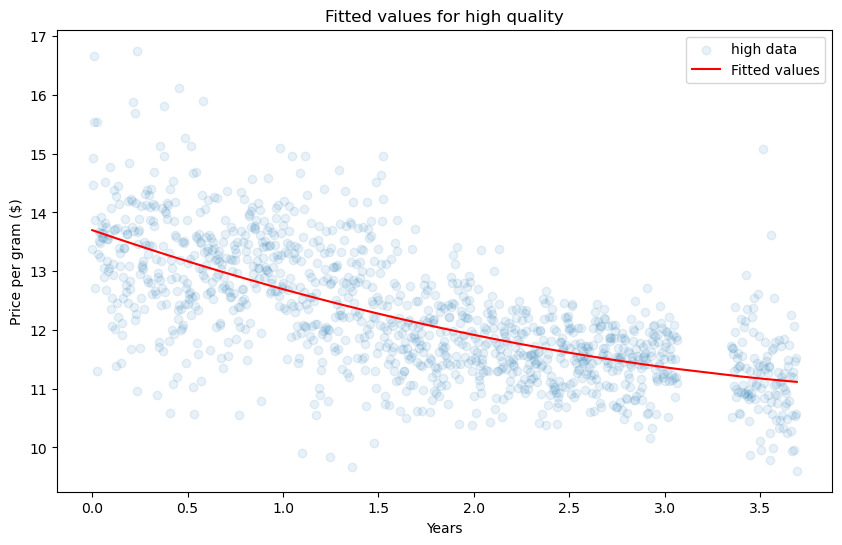

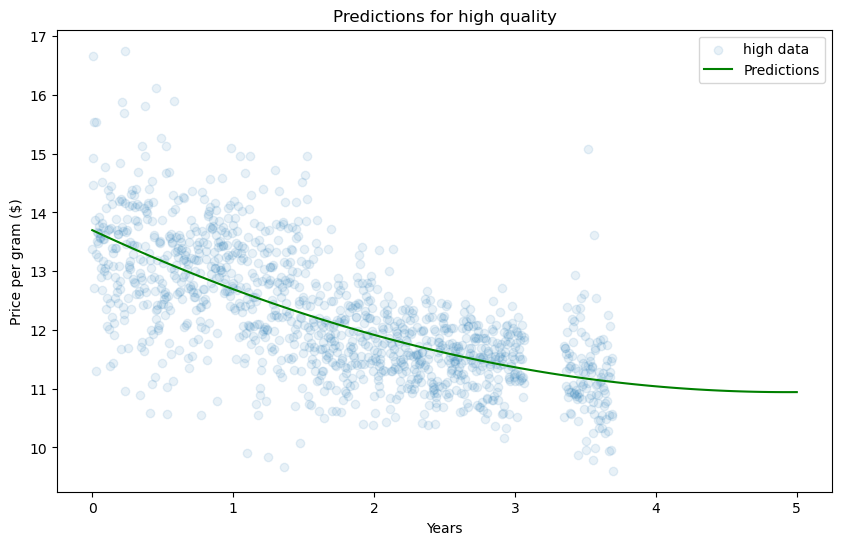

In [57]:
# Import necessary libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import os

# Function to download a file
def download_file(url):
    """
    Downloads a file from the given URL if it does not already exist locally.

    Args:
        url (str): URL of the file to download.

    Returns:
        str: Local filename of the downloaded file.
    """
    filename = os.path.basename(url)
    if not os.path.exists(filename):
        local, _ = urlretrieve(url, filename)
        print(f"Downloaded {local}")
    return filename

# Download the dataset
file_url = "https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv"
download_file(file_url)

# Load the dataset
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])

# Create Groups by Day
def GroupByDay(transactions, func=np.mean):
    """
    Groups transactions by day and calculates the mean price per gram.

    Args:
        transactions (DataFrame): DataFrame containing transaction data.
        func (function): Aggregation function to apply (default is np.mean).

    Returns:
        DataFrame: Daily aggregated data with 'date', 'ppg', and 'years' columns.
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]

    # Calculate the difference in days and convert to years
    daily['years'] = (daily.date - start) / np.timedelta64(1, 'D') / 365.25

    return daily

# Create Quality Groups
def GroupByQualityAndDay(transactions):
    """
    Groups transactions by quality and then by day.

    Args:
        transactions (DataFrame): DataFrame containing transaction data.

    Returns:
        dict: A dictionary where keys are quality groups and values are daily DataFrames.
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)
    
    return dailies

# Function to run a quadratic model
def RunQuadraticModel(daily):
    """
    Fits a quadratic model to the daily prices data.

    Args:
        daily (DataFrame): DataFrame containing 'ppg' (price per gram) and 'years' columns.

    Returns:
        model: Fitted OLS model.
        results: Results from the fitted model.
    """
    # Add a quadratic term
    daily["years2"] = daily.years**2

    # Fit the quadratic model
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results

# Group transactions by quality and day
dailies = GroupByQualityAndDay(transactions)

# Select a quality group for analysis 
quality_group = 'high'  
daily = dailies[quality_group]

# Run the quadratic model
model, results = RunQuadraticModel(daily)

# Print the model summary
print(model, results.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.scatter(daily.years, daily.ppg, alpha=0.1, label=f"{quality_group} data")
plt.plot(daily.years, results.fittedvalues, label="Fitted values", color='red')
plt.title(f"Fitted values for {quality_group} quality")
plt.xlabel("Years")
plt.ylabel("Price per gram ($)")
plt.legend()
plt.show()

# Generate predictions and plot
years = np.linspace(0, 5, 101)  # Create a range of years for predictions
predictions = results.predict(exog=dict(years=years, years2=years**2))

plt.figure(figsize=(10, 6))
plt.scatter(daily.years, daily.ppg, alpha=0.1, label=f"{quality_group} data")
plt.plot(years, predictions, label="Predictions", color='green')
plt.title(f"Predictions for {quality_group} quality")
plt.xlabel("Years")
plt.ylabel("Price per gram ($)")
plt.legend()
plt.show()

Exercise 12-2

Write a definition for a class named SerialCorrelationTest that extends HypothesisTest from the section "HypothesisTest" on page 102. This class should take a series and a lag as input data, compute the serial correlation of the series with the specified lag, and then calculate the p-value of the observed correlation.

Use this class to test whether the serial correlation in the raw price data is statistically significant. Additionally, test the residuals of the linear model and, if you completed the previous exercise, the residuals of the quadratic model.

In [63]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import thinkstats2
import thinkplot

# Base HypothesisTest class
class HypothesisTest:
    def __init__(self, data):
        """
        Initialize the hypothesis test with the given data.
        """
        self.data = data
        self.MakeModel()  # Set up the model for the test
        self.actual = self.TestStatistic(data)  # Calculate the actual test statistic

    def PValue(self, iters=1000):
        """
        Calculate the p-value by simulating the test statistic under the null hypothesis.
        """
        self.test_stats = [self.TestStatistic(pd.Series(self.RunModel())) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        """
        Calculate the test statistic. This method should be overridden by subclasses.
        """
        raise NotImplementedError("TestStatistic method must be implemented in subclass")

    def MakeModel(self):
        """
        Set up the model for the hypothesis test. This method should be overridden by subclasses.
        """
        raise NotImplementedError("MakeModel method must be implemented in subclass")

    def RunModel(self):
        """
        Run the model to generate simulated data under the null hypothesis.
        This method should be overridden by subclasses.
        """
        raise NotImplementedError("RunModel method must be implemented in subclass")


# Function to process daily transactions and compute time series
def GroupByDay(transactions, func=np.mean):
    """
    Groups transactions by day and computes the daily mean ppg.

    Args:
        transactions (pd.DataFrame): DataFrame of transactions.
        func (function): Aggregation function to apply (default is np.mean).

    Returns:
        pd.DataFrame: Daily aggregated data with 'date', 'ppg', and 'years' columns.
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(365, 'D')
    daily['years'] = (daily.date - start) / one_year

    return daily


# Serial Correlation Hypothesis Test
class SerialCorrelationTest(HypothesisTest):
    def __init__(self, series, lag):
        """
        Initialize the SerialCorrelationTest.

        Args:
            series (pd.Series): The time series data.
            lag (int): The lag for computing serial correlation.
        """
        self.series = series.dropna()  # Drop missing values
        self.lag = lag
        super().__init__(self.series)  # Initialize the base class

    def TestStatistic(self, series):
        """
        Compute the serial correlation with the specified lag.

        Args:
            series (pd.Series): The time series data.

        Returns:
            float: The serial correlation at the given lag.
        """
        return series.autocorr(self.lag)

    def MakeModel(self):
        """
        No specific model is needed for the serial correlation test.
        """
        pass

    def RunModel(self):
        """
        Simulate the null hypothesis by shuffling the series.

        Returns:
            pd.Series: The shuffled series.
        """
        shuffled = np.random.permutation(self.series)
        return pd.Series(shuffled)


# Define the RunQuadraticModel function
def RunQuadraticModel(daily):
    """
    Fit a quadratic model to the daily data.

    Args:
        daily (pd.DataFrame): Daily aggregated data with 'ppg' and 'years' columns.

    Returns:
        statsmodels.regression.linear_model.RegressionResultsWrapper: Fitted quadratic model.
    """
    daily['years2'] = daily['years']**2  # Add quadratic term
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return results


# Load the dataset
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])

# Group transactions by day
daily = GroupByDay(transactions)

# Select a quality group for analysis 
quality_group = 'high'  
daily = dailies[quality_group]

# Fit the linear model
results_linear = smf.ols('ppg ~ years', data=daily).fit()

# Fit the quadratic model
results_quadratic = RunQuadraticModel(daily)

# Test serial correlation in raw price data
raw_correlation_test = SerialCorrelationTest(daily['ppg'], lag=1)
print('Raw price data serial correlation:', raw_correlation_test.actual)
print('Raw price data serial correlation p-value:', raw_correlation_test.PValue())

# Test serial correlation in residuals of the linear model
residuals_linear = results_linear.resid
linear_correlation_test = SerialCorrelationTest(residuals_linear, lag=1)
print('Linear model residuals serial correlation:', linear_correlation_test.actual)
print('Linear model residuals serial correlation p-value:', linear_correlation_test.PValue())

# Test serial correlation in residuals of the quadratic model
residuals_quadratic = results_quadratic.resid
quadratic_correlation_test = SerialCorrelationTest(residuals_quadratic, lag=1)
print('Quadratic model residuals serial correlation:', quadratic_correlation_test.actual)
print('Quadratic model residuals serial correlation p-value:', quadratic_correlation_test.PValue())

Raw price data serial correlation: 0.485229376194738
Raw price data serial correlation p-value: 0.0
Linear model residuals serial correlation: 0.07570473767506261
Linear model residuals serial correlation p-value: 0.001
Quadratic model residuals serial correlation: 0.05607308161289923
Quadratic model residuals serial correlation p-value: 0.024
